In [1]:
import os
import sys

notebook_dir = os.getcwd()
project_root_path = os.path.dirname(notebook_dir)
sys.path.insert(0, project_root_path)

from config import PROJECT_ROOT
import numpy as np

import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F

In [2]:
C_hat_train = np.load(os.path.join(PROJECT_ROOT, 'output', 'C_hat_sigmoid_train.npy'))
Y_train = np.load(os.path.join(PROJECT_ROOT, 'output', 'Y_train.npy'))

C_hat_test = np.load(os.path.join(PROJECT_ROOT, 'output', 'C_hat_sigmoid_test.npy'))
Y_test = np.load(os.path.join(PROJECT_ROOT, 'output', 'Y_test.npy'))

class_level_concepts = np.load(os.path.join(PROJECT_ROOT, 'output', 'class_level_concepts.npy'))
instance_level_concepts = np.load(os.path.join(PROJECT_ROOT, 'output', 'instance_level_concepts.npy'))

print(C_hat_train.shape, Y_train.shape, C_hat_test.shape, Y_test.shape, class_level_concepts.shape, instance_level_concepts.shape)

# C_hat_train[C_hat_train<0.5] = 0
# C_hat_train[C_hat_train>0.5] = 1
# C_hat_test[C_hat_test<0.5] = 0
# C_hat_test[C_hat_test>0.5] = 1
C_hat_train = C_hat_train.round(2)
C_hat_test = C_hat_test.round(2)
# C_hat_train[C_hat_train<0.5] = 0
# C_hat_test[C_hat_test<0.5] = 0

(5994, 112) (5994, 200) (5794, 112) (5794, 200) (200, 112) (11788, 112)


### Concept accuracy

In [3]:
real_concepts_train = np.empty_like(C_hat_train)
real_labels_train = Y_train.argmax(axis=1)
for i in range(len(Y_train)):
    label = real_labels_train[i]
    real_concepts_train[i,:] = class_level_concepts[label, :]

C_hat_train_ninary = C_hat_train.copy()
C_hat_train_ninary[C_hat_train_ninary<0.5] = 0
C_hat_train_ninary[C_hat_train_ninary>=0.5] = 1

(C_hat_train_ninary==real_concepts_train).mean(axis=0)

array([0.98148148, 0.97797798, 0.92325659, 0.96046046, 0.94294294,
       0.93960627, 0.9676343 , 0.90106773, 0.95095095, 0.96279613,
       0.96229563, 0.90690691, 0.97180514, 0.91041041, 0.95962629,
       0.96229563, 0.97347347, 0.97280614, 0.98448448, 0.94961628,
       0.91257925, 0.95111778, 0.94344344, 0.9676343 , 0.95879213,
       0.93109776, 0.91307975, 0.98815482, 0.93209877, 0.9711378 ,
       0.94794795, 0.81664998, 0.93560227, 0.8983984 , 0.90056723,
       0.9676343 , 0.9631298 , 0.98014681, 0.9297631 , 0.97364031,
       0.9631298 , 0.98014681, 0.94427761, 0.94778111, 0.95328662,
       0.98248248, 0.9954955 , 0.95812479, 0.96146146, 0.97414081,
       0.98732065, 0.97414081, 0.97814481, 0.99783116, 0.94744745,
       0.97497497, 0.9964965 , 0.92308976, 0.98648649, 0.9317651 ,
       0.90423757, 0.92559226, 0.96680013, 0.96796797, 0.95295295,
       0.97230564, 0.99282616, 0.96329663, 0.9661328 , 0.94394394,
       0.97864531, 0.97297297, 0.97414081, 0.97614281, 0.92559

In [4]:
real_concepts_test = np.empty_like(C_hat_test)
real_labels_test = Y_test.argmax(axis=1)
for i in range(len(Y_test)):
    label = real_labels_test[i]
    real_concepts_test[i,:] = class_level_concepts[label, :]

C_hat_test_ninary = C_hat_test.copy()
C_hat_test_ninary[C_hat_test_ninary<0.5] = 0
C_hat_test_ninary[C_hat_test_ninary>=0.5] = 1

(C_hat_test_ninary==real_concepts_test).mean(axis=0)

array([0.96824301, 0.96582672, 0.87763203, 0.92474974, 0.91025198,
       0.88539869, 0.95305488, 0.84639282, 0.9099068 , 0.93993787,
       0.92544011, 0.85916465, 0.95478081, 0.85916465, 0.93165343,
       0.93717639, 0.95806006, 0.95253711, 0.9616845 , 0.9278564 ,
       0.83293062, 0.9257853 , 0.88177425, 0.95823265, 0.95063859,
       0.90455644, 0.86468761, 0.97393856, 0.89696237, 0.95788747,
       0.9256127 , 0.78667587, 0.90645495, 0.86831205, 0.86365205,
       0.95150155, 0.94131861, 0.97411115, 0.8986883 , 0.95909562,
       0.95253711, 0.95909562, 0.92147049, 0.87625129, 0.92958233,
       0.9730756 , 0.97169486, 0.92354159, 0.89782534, 0.95736969,
       0.98049707, 0.92423196, 0.92440456, 0.99033483, 0.92440456,
       0.94131861, 0.97462893, 0.8671039 , 0.96720746, 0.91646531,
       0.87694166, 0.86848464, 0.94615119, 0.94770452, 0.93061788,
       0.91905419, 0.97894373, 0.91404902, 0.94183638, 0.92975492,
       0.97031412, 0.95806006, 0.95460822, 0.95857784, 0.84691

In [5]:
# on training set
dists = np.sum(np.abs(C_hat_train[:, np.newaxis, :] - class_level_concepts[np.newaxis, :, :]), axis=2)
Y_hat = dists.argmin(axis=1)
min_dists = dists.min(axis=1)
Y_real = np.argmax(Y_train, axis=1)
sum(Y_hat==Y_real)/len(Y_real)

np.float64(0.8835502168835502)

In [6]:
# on test set
dists = np.sum(np.abs(C_hat_test[:, np.newaxis, :] - class_level_concepts[np.newaxis, :, :]), axis=2)
Y_hat = dists.argmin(axis=1)
min_dists = dists.min(axis=1)
Y_real = np.argmax(Y_test, axis=1)
sum(Y_hat==Y_real)/len(Y_real)

np.float64(0.6151190887124611)

In [7]:
clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
clf.fit(C_hat_train, Y_train.argmax(axis=1))
y_pred = clf.predict(C_hat_test)

acc = accuracy_score(Y_test.argmax(axis=1), y_pred)
print(f"Test Accuracy: {acc:.4f}")

/Users/pb/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Accuracy: 0.6647


In [8]:
y_pred = clf.predict(C_hat_train)
acc = accuracy_score(Y_train.argmax(axis=1), y_pred)
print(f"Training Accuracy: {acc:.4f}")

Training Accuracy: 0.9635


In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(C_hat_train)
X_test = scaler.transform(C_hat_test)

clf = MLPClassifier(hidden_layer_sizes=(512, 256, 128),
                    activation='relu',
                    solver='adam',
                    max_iter=200,
                    random_state=42)

clf.fit(X_train, Y_train.argmax(axis=1))

y_pred = clf.predict(X_test)

acc = accuracy_score(Y_test.argmax(axis=1), y_pred)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.6505


In [10]:
clf = DecisionTreeClassifier(criterion='entropy',
                              max_depth=None,
                              random_state=None)

clf.fit(C_hat_train, Y_train.argmax(axis=1))

y_pred = clf.predict(C_hat_test)

acc = accuracy_score(Y_test.argmax(axis=1), y_pred)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.6125


### Our proposed model

In [11]:
C_hat_train, C_hat_val, Y_train, Y_val = train_test_split(C_hat_train, Y_train, test_size=0.2, random_state=None)

X_train = torch.tensor(C_hat_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
train_dataset = TensorDataset(X_train, Y_train)
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

X_val = torch.tensor(C_hat_val, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)
val_dataset = TensorDataset(X_val, Y_val)
batch_size = 64
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

X_test = torch.tensor(C_hat_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)
test_dataset = TensorDataset(X_test, Y_test)
batch_size = 64
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
class PrototypeClassifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.P = nn.Parameter(torch.rand(num_classes, num_features))  # initialize the protptype matrix P
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (batch_size, num_features)
        # L1distance：|x_i - M_m|_1
        # (batch_size, num_classes, num_features)
        dist = torch.abs(x.unsqueeze(1) - self.sigmoid(self.P))
        dist = dist.sum(dim=2)
        return dist  # (batch_size, num_classes)

    def binary_regularization(self):
        return (self.sigmoid(self.P) * (1 - self.sigmoid(self.P))).mean()

    def sparsity_regularization(self):
        return torch.sum(self.sigmoid(self.P))

    def predict(self, x):
        with torch.no_grad():
            Prototypes = self.sigmoid(self.P)
            Prototypes[Prototypes>=0.5] = 1
            Prototypes[Prototypes<0.5]= 0
            dists = torch.abs(x.unsqueeze(1) - Prototypes)
            dists = dists.sum(dim=2)
            predictions = dists.argmin(dim=1)
        return predictions

    def concept_wise_dist(self, x):
        with torch.no_grad():
            Prototypes = self.sigmoid(self.P)
            Prototypes[Prototypes>=0.5] = 1
            Prototypes[Prototypes<0.5]= 0
            dists = x.unsqueeze(1) - Prototypes
            # predictions = self.predict(x)
            # dists = dists[torch.arange(x.shape[0]), predictions,:]
        return dists

    def threshold(self, val_x, val_y):
        pass

    def conformal_predict(self, x):
        pass

    def explanation(self, x):
        pass

In [13]:
# Training function
def train_epoch(model, train_dataloader, optimizer, lambda_binary, lambda_L1):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for x_batch, y_batch in train_dataloader:
        dist = model(x_batch)

        # label loss
        loss_cls = (dist*y_batch).sum(axis=1)
        loss_cls = loss_cls.mean()

        # regularization loss
        loss_binary = model.binary_regularization()
        loss_sparsity = model.sparsity_regularization()

        # total loss
        loss = loss_cls + (lambda_binary * loss_binary) + (lambda_L1 * loss_sparsity)

        # back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accumulative training loss
        total_loss += loss.item()

        # calculate the prediction accuracy
        predicted = dist.argmin(dim=1)
        real_labels = y_batch.argmax(dim=1)
        correct += (predicted == real_labels).sum().item()
        total += x_batch.size(0)

    avg_loss = total_loss / len(train_dataloader)
    accuracy = correct / total * 100
    return avg_loss, accuracy

In [14]:
# test function
def val_epoch(model, val_dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in val_dataloader:
            dist = model(x_batch)

            predicted = dist.argmin(dim=1)
            real_labels = y_batch.argmax(dim=1)
            correct += (predicted == real_labels).sum().item()
            total += x_batch.size(0)

    accuracy = correct / total * 100
    return accuracy

In [15]:
num_concepts = 112
num_classes = 200
model = PrototypeClassifier(num_concepts, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lambda_binary = 0.01
lambda_L1 = 0.001

In [16]:
# train and test
num_epochs = 200
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, lambda_binary, lambda_L1)
    val_accuracy = val_epoch(model, val_dataloader)
    if((epoch+1)%10==0):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

Epoch [10/200]
Train Loss: 65.6139, Train Accuracy: 74.01%, Validation Accuracy: 71.31%
Epoch [20/200]
Train Loss: 53.6803, Train Accuracy: 87.70%, Validation Accuracy: 86.91%
Epoch [30/200]
Train Loss: 43.0849, Train Accuracy: 90.49%, Validation Accuracy: 89.49%
Epoch [40/200]
Train Loss: 34.4428, Train Accuracy: 91.22%, Validation Accuracy: 90.08%
Epoch [50/200]
Train Loss: 27.7269, Train Accuracy: 92.05%, Validation Accuracy: 90.66%
Epoch [60/200]
Train Loss: 22.6191, Train Accuracy: 93.03%, Validation Accuracy: 92.08%
Epoch [70/200]
Train Loss: 18.7610, Train Accuracy: 93.76%, Validation Accuracy: 93.16%
Epoch [80/200]
Train Loss: 15.8418, Train Accuracy: 94.10%, Validation Accuracy: 93.83%
Epoch [90/200]
Train Loss: 13.6220, Train Accuracy: 94.22%, Validation Accuracy: 93.83%
Epoch [100/200]
Train Loss: 11.9235, Train Accuracy: 94.20%, Validation Accuracy: 93.83%
Epoch [110/200]
Train Loss: 10.6176, Train Accuracy: 94.22%, Validation Accuracy: 93.83%
Epoch [120/200]
Train Loss: 9.

In [17]:
real_labels = Y_test.argmax(dim=1)
predictions = model.predict(X_test)
(predictions == real_labels).sum().item()/len(predictions)

0.6577493959268208

### Relation between the prediction accuracy and the distance to the closest class

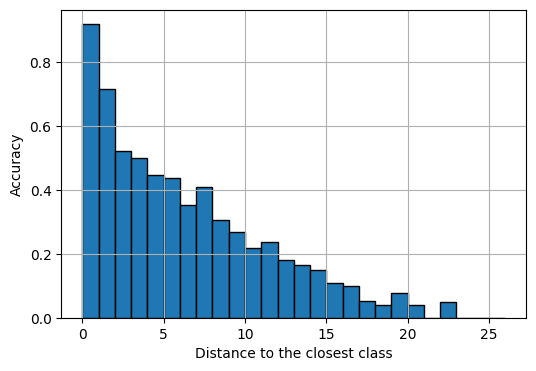

In [18]:
with torch.no_grad():
    dists = model(X_test)
min_dists = dists.min(dim=1).values.numpy()
orders = min_dists.argsort()
min_dists.sort()
threshold = min_dists[orders[int(0.9*len(min_dists))]]
max_min_dist = min_dists.max()

real_labels = Y_test.argmax(dim=1)
predictions = model.predict(X_test)
matching_array = (predictions == real_labels).numpy()
matching_array = matching_array[orders]
n_bins = int(max_min_dist) + 1
bin_acc = np.zeros(n_bins)
for i in range(0, n_bins):
    index = (min_dists>=i) * (min_dists<=(i+1))
    bin_acc[i] = matching_array[index].mean()
# plt.plot(range(0, n_bins), bin_acc)
bin_edges = np.linspace(0, n_bins, n_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.figure(figsize=(6, 4))
plt.bar(bin_centers, bin_acc, width=bin_edges[1] - bin_edges[0], edgecolor='black')
plt.xlabel('Distance to the closest class')
plt.ylabel('Accuracy')
# plt.title('Distance Distribution')
plt.grid(True)
plt.show()

/var/folders/_9/4sprgpf55g9fqk73fyc2s_0w0000gn/T/ipykernel_1591/3739147654.py:17: RuntimeWarning: Mean of empty slice.
  bin_acc[i] = matching_array[index].mean()
/Users/pb/.pyenv/versions/3.11.9/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


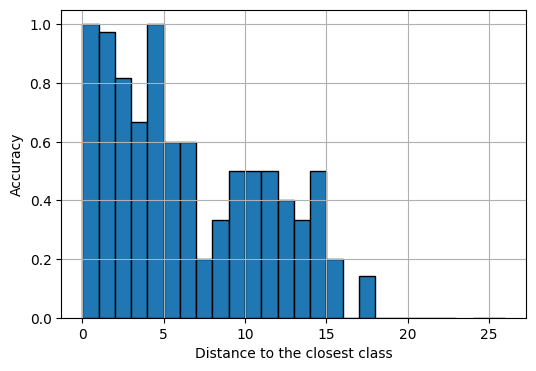

In [19]:
with torch.no_grad():
    dists = model(X_val)
min_dists = dists.min(dim=1).values.numpy()
orders = min_dists.argsort()
min_dists.sort()
threshold = min_dists[orders[int(0.9*len(min_dists))]]
max_min_dist = min_dists.max()

real_labels = Y_val.argmax(dim=1)
predictions = model.predict(X_val)
matching_array = (predictions == real_labels).numpy()
matching_array = matching_array[orders]
n_bins = int(max_min_dist) + 1
bin_acc = np.zeros(n_bins)
for i in range(0, n_bins):
    index = (min_dists>=i) * (min_dists<=(i+1))
    bin_acc[i] = matching_array[index].mean()
# plt.plot(range(0, n_bins), bin_acc)
bin_edges = np.linspace(0, n_bins, n_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.figure(figsize=(6, 4))
plt.bar(bin_centers, bin_acc, width=bin_edges[1] - bin_edges[0], edgecolor='black')
plt.xlabel('Distance to the closest class')
plt.ylabel('Accuracy')
# plt.title('Distance Distribution')
plt.grid(True)
plt.show()

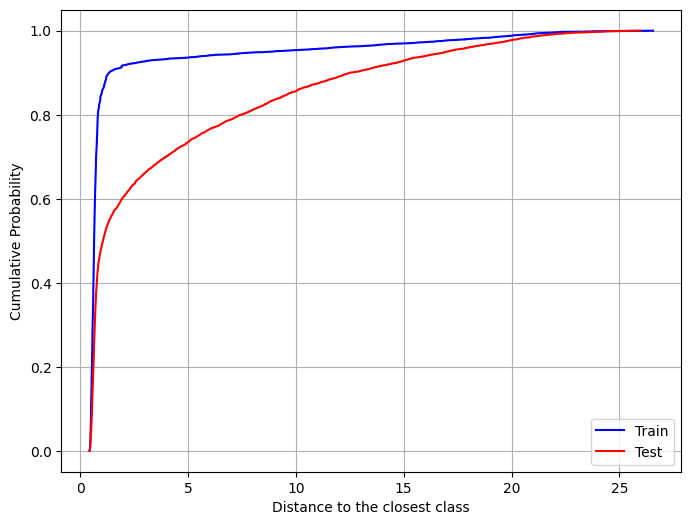

In [20]:
with torch.no_grad():
    train_dists = model(X_train)
    test_dists = model(X_test)
train_min_dists = train_dists.min(dim=1).values.numpy()
test_min_dists = test_dists.min(dim=1).values.numpy()

train_min_dists = np.sort(train_min_dists)
test_min_dists = np.sort(test_min_dists)

cdf_train = np.arange(1, len(train_min_dists)+1) / len(train_min_dists)
cdf_test = np.arange(1, len(test_min_dists)+1) / len(test_min_dists)

plt.figure(figsize=(8, 6))
plt.plot(train_min_dists, cdf_train, label='Train', color='blue')
plt.plot(test_min_dists, cdf_test, label='Test', color='red')
plt.xlabel('Distance to the closest class')
plt.ylabel('Cumulative Probability')
# plt.title('Cumulative Distribution Functions (CDF)')
plt.grid(True)
plt.legend()
plt.show()

### Relation between the prediction accuracy and the lenght of concept list

[0.83333333 0.93333333 0.6        0.73333333 0.5        0.9
 0.73333333 0.6        0.63333333 0.63333333 0.56666667 0.77777778
 0.86666667 0.8        0.76666667 0.4        0.66666667 0.93333333
 0.8        0.5        0.76666667 0.57894737 0.89285714 0.48275862
 0.83333333 0.76666667 0.76666667 0.76666667 0.77777778 0.66666667
 0.62068966 0.66666667 0.8        0.44827586 0.6        0.76666667
 0.76666667 0.66666667 0.66666667 0.8        0.52173913 0.82142857
 0.73076923 0.7        0.83333333 0.86666667 0.56666667 0.4
 0.76666667 0.78571429 0.86206897 0.66666667 0.43333333 0.63333333
 0.4137931  0.37931034 0.8        0.6        0.7        0.43333333
 0.4        0.76666667 0.66666667 0.83333333 0.48275862 0.83333333
 0.8        0.91304348 0.8        0.68965517 0.73333333 0.43333333
 0.7        0.82758621 0.53333333 0.73333333 0.73333333 0.5862069
 0.63333333 0.66666667 0.73333333 0.31034483 0.9        0.83333333
 0.53333333 0.59090909 0.26666667 0.53333333 0.9047619  0.5
 0.3        0.2  

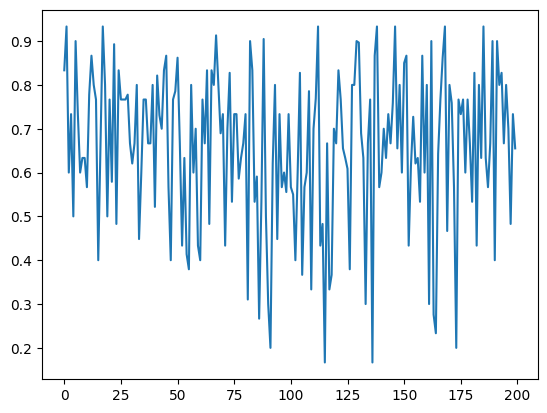

In [21]:
real_labels = Y_test.argmax(dim=1)
predictions = model.predict(X_test)
matching_array = (predictions == real_labels).numpy()

prototypes = expit(model.P.cpu().detach().numpy())
prototypes[prototypes<0.5] = 0
prototypes[prototypes>0.5] = 1

class_n_concetps = prototypes.sum(axis=1)
class_order = class_n_concetps.argsort()
class_n_concetps.sort()

accuracy_list = np.zeros(len(class_n_concetps))

for i in range(len(class_n_concetps)):
    label = class_order[i]
    index = real_labels==label
    accuracy_list[i] = matching_array[index].mean()
print(accuracy_list)
plt.plot(accuracy_list)

### Comparison between prediction and real label
CNN会错误激活很多不相关的概念（假阳性）

In [22]:
prototypes = expit(model.P.cpu().detach().numpy())
prototypes[prototypes<0.5] = 0
prototypes[prototypes>0.5] = 1

In [23]:
dists = model.concept_wise_dist(X_test) # [5794, 200, 112]
real_labels = Y_test.argmax(dim=1)
predictions = model.predict(X_test)

# to calculate how many false positive and false negative

count_incorrect = 0
fp_incorrect = 0
fn_incorrect = 0
for i in range(len(predictions)):
    if real_labels[i] != predictions[i]:
        count_incorrect += 1
        real_label = real_labels[i]
        concept_activation = X_test[i, :]
        for k in range(len(concept_activation)):
            if concept_activation[k] < 0.5 and class_level_concepts[real_label, k]==1:
                fn_incorrect += 1
            if concept_activation[k] >= 0.5 and class_level_concepts[real_label, k]==0:
                fp_incorrect += 1

print(fp_incorrect/count_incorrect, fn_incorrect/count_incorrect)

count_correct = 0
fp_correct = 0
fn_correct = 0
for i in range(len(predictions)):
    if real_labels[i] == predictions[i]:
        count_correct += 1
        real_label = real_labels[i]
        concept_activation = X_test[i, :]
        for k in range(len(concept_activation)):
            if concept_activation[k] < 0.5 and class_level_concepts[real_label, k]==1:
                fn_correct += 1
            if concept_activation[k] >= 0.5 and class_level_concepts[real_label, k]==0:
                fp_correct += 1

print(fp_correct/count_correct, fn_correct/count_correct)
# index 3: 0 -> 1
# index 4: 0 -> 2
# index 5: 0 -> 1
# index = 1

# predicted_distance = dists[index, predictions[index],:]
# real_label_distance = dists[index, real_labels[index],:]
# print(torch.abs(predicted_distance).sum(), torch.abs(real_label_distance).sum())


6.696923852748361 8.544125063035805
3.241668853319339 1.942797166098137


In [24]:
(fp_incorrect+fn_incorrect)/(count_incorrect*112), (fp_correct+fn_correct)/(count_correct*112)

(0.13608079389093006, 0.04628987517337032)

In [25]:
(fp_incorrect+fn_incorrect+fp_correct+fn_correct)/((count_incorrect+count_correct)*112)

0.07702087134474087

In [27]:
predicted_concept_list = np.where(prototypes[predictions[index]]==1)[0]
print(predicted_concept_list)
# predicted_distance[predicted_concept_list], torch.abs(predicted_distance[predicted_concept_list]).sum()

[ 0  0  0 ... 28 28 28]


In [29]:
real_label_concept_list = np.where(prototypes[real_labels[index]]==1)[0]
print(real_label_concept_list)
# real_label_distance[real_label_concept_list], torch.abs(real_label_distance[real_label_concept_list]).sum()

[ 0  0  0 ... 28 28 28]


In [30]:
np.where(X_test[index]>0)[0], X_test[index][X_test[index]>0]

(array([ 0,  0,  0, ..., 28, 28, 28], shape=(1841,)),
 tensor([0.9500, 0.1300, 0.2200,  ..., 0.9200, 0.0300, 1.0000]))

In [31]:
X_test[index][real_label_concept_list]

tensor([[0.0000, 0.0000, 0.9500,  ..., 0.0000, 0.0900, 0.0100],
        [0.0000, 0.0000, 0.9500,  ..., 0.0000, 0.0900, 0.0100],
        [0.0000, 0.0000, 0.9500,  ..., 0.0000, 0.0900, 0.0100],
        ...,
        [0.0000, 0.0000, 0.0200,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0200,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0200,  ..., 0.0000, 1.0000, 0.0000]])

In [32]:
np.where(class_level_concepts[real_labels[index]]==1)[0],X_test[index][np.where(class_level_concepts[real_labels[index]]==1)[0]]

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7, 

In [33]:
np.where(class_level_concepts[predictions[index]]==1)[0],X_test[index][np.where(class_level_concepts[predictions[index]]==1)[0]]

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         8, 

In [34]:
M = model.P.cpu().detach().numpy()
prototypes = expit(M.copy())
prototypes[prototypes<0.5] = 0
prototypes[prototypes>0.5] = 1

dists = np.sum(np.abs(class_level_concepts[np.newaxis, :, :] - X_test[:, np.newaxis, :]), axis=2)
Y_hat = dists.argmin(axis=1)

dists = class_level_concepts[np.newaxis, :, :] - X_test[:, np.newaxis, :]
dists = dists[np.arange(dists.shape[0]), Y_test, :]
dists.shape

TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'

In [35]:
M = model.P.cpu().detach().numpy()
prototypes = expit(M.copy())
prototypes
# prototypes[prototypes<0.5] = 0
# prototypes[prototypes>0.5] = 1
# prototypes.sum(axis=1)

array([[0.00462862, 0.9958188 , 0.00501173, ..., 0.00347157, 0.00431206,
        0.00496754],
       [0.00412695, 0.99023366, 0.0048944 , ..., 0.00365641, 0.00582049,
        0.00594629],
       [0.00555341, 0.9852485 , 0.00587484, ..., 0.00399974, 0.00627695,
        0.00492963],
       ...,
       [0.98844725, 0.00351554, 0.00481203, ..., 0.99152803, 0.00538532,
        0.00652476],
       [0.0052886 , 0.00589621, 0.9859827 , ..., 0.0055266 , 0.00616012,
        0.00402967],
       [0.00368708, 0.00320442, 0.99385464, ..., 0.00461174, 0.00339779,
        0.00488467]], shape=(200, 112), dtype=float32)

### Distance to the closest class as confidance

In [36]:
with torch.no_grad():
    dists = model(X_val)
min_dists = dists.min(dim=1).values.numpy()
real_labels = Y_val.argmax(dim=1)
predictions = model.predict(X_val)
matching_array = (predictions == real_labels).numpy()
min_dists = min_dists[matching_array]
min_dists.sort()

# the threshold to determin "outliers"
# outlier if its distance to the closest class is larger than 98% of that got on validation set
threshold = min_dists[int(0.98*len(min_dists))]

with torch.no_grad():
    test_dists = model(X_test)
test_min_dists = test_dists.min(dim=1).values.numpy()
index = test_min_dists <= threshold

real_labels = Y_test.argmax(dim=1)
predictions = model.predict(X_test)

print(f"Proportion of inlier instance: {100*index.mean():.2f}%")
inlier_acc = 100*(predictions[index]==real_labels[index]).numpy().mean()
outlier_acc = 100*(predictions[~index]==real_labels[~index]).numpy().mean()
print(f"Inlier Accuracy: {inlier_acc:.2f}%, outlier Accuracy: {outlier_acc:.2f}%")

Proportion of inlier instance: 68.59%
Inlier Accuracy: 83.79%, outlier Accuracy: 26.43%


In [37]:
threshold

np.float32(3.5847664)